# Tutorial para OSF

En este notebook se enseña a maneja el servidor OSF para su posterior uso en la interfaz gráfica del proyecto CuboLab.

## Usario en OSF y su token

En la página de OSF.io https://osf.io/, creamos una sesión para nuestro usuario en Sign up.

Después, creamos un token. Para ello, en Settings -> Personal Access Tokens -> Create token.

(Como se muestra en la imagen)

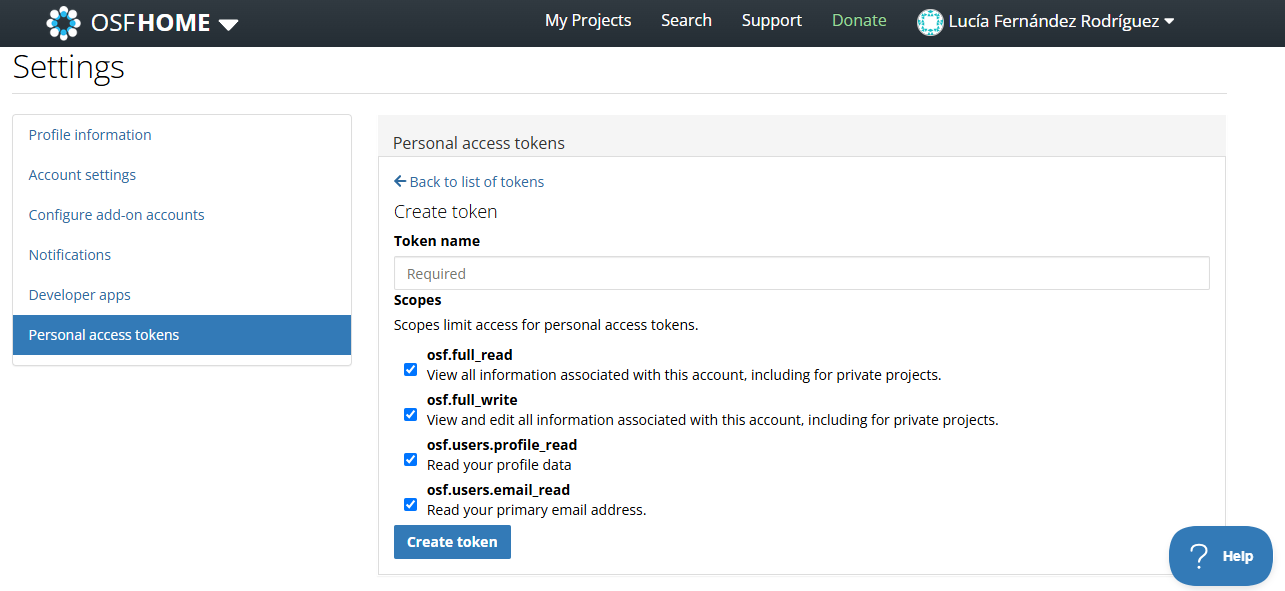

## Crear proyectos y subir archivos

Para crear un proyecto en OSF donde guardaremos nuestras bases de datos, podemos hacerlo de dos formas:

- Desde la página web. Ir a Create new project. Después en Files, concretamente en "OSF Storage (United States)" arrastrar las bases de datos u archivos que queramos ahí.

- Desde el siguiente script python. No hay que modificar nada del código, al ejecutarlo ya solicita la token de usuario. Luego también te preguntará si quieres subir los archivos a un proyecto ya creado o a uno nuevo. En el caso de ser un proyecto ya creado, se solicita el id del proyecto.

El ID de un proyecto en OSF es un identificador único de cinco caracteres alfanuméricos que aparece en la URL del proyecto.

Cómo encontrar el ID de un proyecto en OSF
1. Abre tu proyecto en OSF: Ve a la página del proyecto que quieres usar.
2. Observa la URL: La URL del proyecto tendrá un formato similar a https://osf.io/abcd1/.

El ID del proyecto sería abcd1


In [ ]:
import requests
import json
import os

# Pedir al usuario que ingrese su token de OSF
osf_token = input("Introduce tu token de acceso personal de OSF: ").strip()

# Función para verificar si el token de acceso es válido
def verificar_token_osf(token):
    url = "https://api.osf.io/v2/users/me/"
    headers = {"Authorization": f"Bearer {token}"}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        print("El token es válido.")
        return True
    else:
        print("El token no es válido:", response.text)
        return False

# Función para crear un proyecto en OSF
def crear_proyecto_osf(nombre_proyecto, descripcion):
    url = "https://api.osf.io/v2/nodes/"
    headers = {
        "Authorization": f"Bearer {osf_token}",
        "Content-Type": "application/json"
    }
    data = {
        "data": {
            "type": "nodes",
            "attributes": {
                "title": nombre_proyecto,
                "description": descripcion,
                "category": "project",
                "public": True  # Cambia a False si prefieres que el proyecto sea privado
            }
        }
    }
    response = requests.post(url, headers=headers, data=json.dumps(data))
    if response.status_code == 201:
        print("Proyecto creado exitosamente.")
        return response.json()["data"]["id"]
    else:
        print("Error al crear el proyecto:", response.text)
        return None

# Función para verificar si un ID de proyecto es válido
def verificar_project_id(project_id):
    url = f"https://api.osf.io/v2/nodes/{project_id}/"
    headers = {"Authorization": f"Bearer {osf_token}"}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        print("El ID del proyecto es válido.")
        return True
    else:
        print("El ID del proyecto no es válido:", response.text)
        return False

# Función para verificar si un archivo ya ha sido subido a OSF
def archivo_existe_osf(project_id, file_name):
    url = f"https://api.osf.io/v2/nodes/{project_id}/files/osfstorage/"
    headers = {"Authorization": f"Bearer {osf_token}"}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        archivos = response.json()["data"]
        for archivo in archivos:
            if archivo["attributes"]["name"] == file_name:
                return True
    return False

# Función para subir un archivo a OSF
def subir_archivo_osf(project_id, file_path):
    file_name = os.path.basename(file_path)
    if archivo_existe_osf(project_id, file_name):
        print(f"El archivo {file_name} ya ha sido subido a OSF.")
        return

    url = f"https://files.osf.io/v1/resources/{project_id}/providers/osfstorage/?name={file_name}"
    headers = {"Authorization": f"Bearer {osf_token}"}
    with open(file_path, 'rb') as file_data:
        files = {'file': file_data}
        response = requests.put(url, headers=headers, files=files)
        if response.status_code in [200, 201]:
            print(f"Archivo {file_name} subido exitosamente.")
        else:
            print(f"Error al subir el archivo {file_name}:", response.text)

# Verificar si el token es válido antes de continuar
if not verificar_token_osf(osf_token):
    print("No se puede continuar. Por favor, proporciona un token válido.")
else:
    # Menú de opciones
    opcion = input("¿Quieres (1) crear un nuevo proyecto o (2) subir archivos a un proyecto existente? Escribe 1 o 2: ")

    if opcion == "1":
        # Crear un nuevo proyecto
        nombre_proyecto = input("Introduce el nombre del proyecto: ")
        descripcion = input("Introduce la descripción del proyecto: ")
        project_id = crear_proyecto_osf(nombre_proyecto, descripcion)
        if project_id:
            archivos_csv = input("Introduce las rutas de los archivos CSV (Ejemplo: bbdd1.csv), si son varios archivos sepáralos por comas: ").split(",")
            for file_path in archivos_csv:
                subir_archivo_osf(project_id, file_path.strip())

    elif opcion == "2":
        # Subir archivos a un proyecto existente
        project_id = input("Introduce el ID del proyecto existente: ")
        if verificar_project_id(project_id):
            archivos_csv = input("Introduce las rutas de los archivos CSV separados por comas: ").split(",")
            for file_path in archivos_csv:
                subir_archivo_osf(project_id, file_path.strip())
        else:
            print("No se puede continuar. Por favor, verifica el ID del proyecto.")
    else:
        print("Opción no válida. Por favor, escribe 1 o 2.")


## Obtener ID de los archivos.

El siguiente código proporciona los ID de cada archivo.

In [ ]:
import requests

# Pedir al usuario que ingrese su token de OSF
osf_token = input("Introduce tu token de acceso personal de OSF: ").strip()

# Función para verificar si el token de acceso es válido
def verificar_token_osf(token):
    url = "https://api.osf.io/v2/users/me/"
    headers = {"Authorization": f"Bearer {token}"}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        print("El token es válido.")
        return True
    else:
        print("El token no es válido:", response.text)
        return False

# Función para obtener los archivos de un proyecto y sus IDs
def obtener_archivos_osf(project_id):
    url = f"https://api.osf.io/v2/nodes/{project_id}/files/osfstorage/"
    headers = {"Authorization": f"Bearer {osf_token}"}
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        archivos = response.json()["data"]
        if not archivos:
            print("No hay archivos en este proyecto.")
        else:
            print("Archivos en el proyecto:")
            for archivo in archivos:
                file_name = archivo["attributes"]["name"]
                file_id = archivo["id"]
                print(f"Nombre: {file_name}, ID: {file_id}")
    else:
        print("Error al obtener los archivos:", response.text)

# Verificar si el token es válido antes de continuar
if not verificar_token_osf(osf_token):
    print("No se puede continuar. Por favor, proporciona un token válido.")
else:
    project_id = input("Introduce el ID del proyecto: ").strip()
    obtener_archivos_osf(project_id)
